**Step 1  Setup and Initialization**

Step 1.1  Importing Necessary Libraries

In [ ]:
# Mengabaikan Peringatan
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter

%matplotlib inline

In [ ]:
# Inisialisasi Plotly untuk digunakan di buku catatan
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [ ]:
# Mengonfigurasikan gaya plot Seaborn: Atur warna latar belakang dan gunakan kisi gelap
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

Step 1.2 Loading the Dataset

In [ ]:
df = pd.read_csv('/content/data.csv', encoding="ISO-8859-1")

**Step 2 Initial Data Analysis**

Step 2.1 Dataset Overview

In [ ]:
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Step 2.2 Summary Statistics

In [ ]:
# Statistik ringkasan untuk variabel numerik
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


In [ ]:
# Statistik ringkasan untuk variabel kategorikal
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
InvoiceDate,541909,23260,10/31/2011 14:41,1114
Country,541909,38,United Kingdom,495478


**Step 3 Data Cleaning & Transformation**

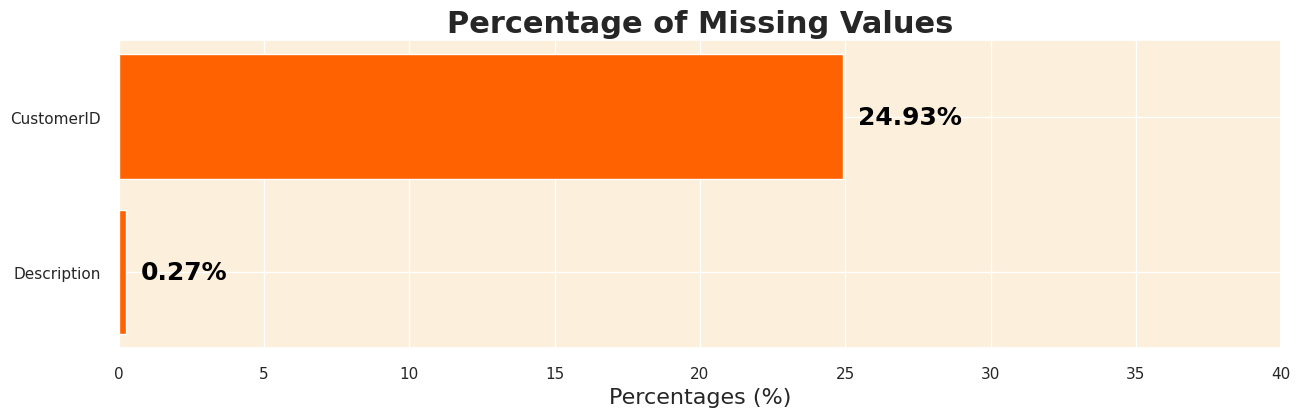

In [ ]:
# Menghitung persentase nilai yang hilang untuk setiap kolom
missing_data = df.isnull().sum()
missing_percentage = (missing_data[missing_data > 0] / df.shape[0]) * 100

# Menyiapkan nilai
missing_percentage.sort_values(ascending=True, inplace=True)

# Mengambarkan diagram barh
fig, ax = plt.subplots(figsize=(15, 4))
ax.barh(missing_percentage.index, missing_percentage, color='#ff6200')

# Memberi anotasi pada nilai dan indeks
for i, (value, name) in enumerate(zip(missing_percentage, missing_percentage.index)):
    ax.text(value+0.5, i, f"{value:.2f}%", ha='left', va='center', fontweight='bold', fontsize=18, color='black')

# Menetapkan batas sumbu x
ax.set_xlim([0, 40])

# Memambahkan judul dan xlabel
plt.title("Percentage of Missing Values", fontweight='bold', fontsize=22)
plt.xlabel('Percentages (%)', fontsize=16)
plt.show()

In [ ]:
# Mengekstrak baris dengan nilai yang hilang di kolom 'CustomerID' atau 'Description'
df[df['CustomerID'].isnull() | df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [ ]:
# Menghapus baris dengan nilai yang hilang di kolom 'CustomerID' dan 'Description'
df = df.dropna(subset=['CustomerID', 'Description'])

In [ ]:
# Memverifikasi penghapusan nilai yang hilang
df.isnull().sum().sum()

np.int64(0)

Step 3.2 Handling Duplicates

In [ ]:
# Menemukan baris duplikat (mempertahankan semua contoh)
duplicate_rows = df[df.duplicated(keep=False)]

# Mengurutkan data berdasarkan kolom tertentu untuk melihat baris duplikat yang bersebelahan
duplicate_rows_sorted = duplicate_rows.sort_values(by=['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Quantity'])

# Menampilkan 10 rekaman pertama
duplicate_rows_sorted.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
578,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom
598,536412,21448,12 DAISY PEGS IN WOOD BOX,1,12/1/2010 11:49,1.65,17920.0,United Kingdom


In [ ]:
# Menampilkan jumlah baris duplikat
print(f"The dataset contains {df.duplicated().sum()} duplicate rows that need to be removed.")

# Menghapus baris duplikat
df.drop_duplicates(inplace=True)

The dataset contains 5225 duplicate rows that need to be removed.


In [ ]:
# Mendapatkan jumlah baris dalam kerangka data
df.shape[0]

401604

Step 3.3 Treating Cancelled Transactions

In [ ]:
# Saring baris dengan InvoiceNo yang dimulai dengan "C" dan buat kolom baru yang menunjukkan status transaksi
df['Transaction_Status'] = np.where(df['InvoiceNo'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

# Analisis karakteristik baris-baris berikut (dengan mempertimbangkan kolom baru)
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancelled_transactions.describe().drop('CustomerID', axis=1)

,Quantity,UnitPrice
count,8872.000000,8872.000000
mean,-30.774910,18.899512
std,1172.249902,445.190864
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


In [ ]:
# Menemukan persentase transaksi yang dibatalkan
cancelled_percentage = (cancelled_transactions.shape[0] / df.shape[0]) * 100

# Mencetak persentase transaksi yang dibatalkan
print(f"The percentage of cancelled transactions in the dataset is: {cancelled_percentage:.2f}%")

The percentage of cancelled transactions in the dataset is: 2.21%


Step 3.4 Correcting StockCode Anomalies

In [ ]:
# Menemukan jumlah kode stok yang unik
unique_stock_codes = df['StockCode'].nunique()

# Mencetak jumlah kode stok unik
print(f"The number of unique stock codes in the dataset is: {unique_stock_codes}")

The number of unique stock codes in the dataset is: 3684


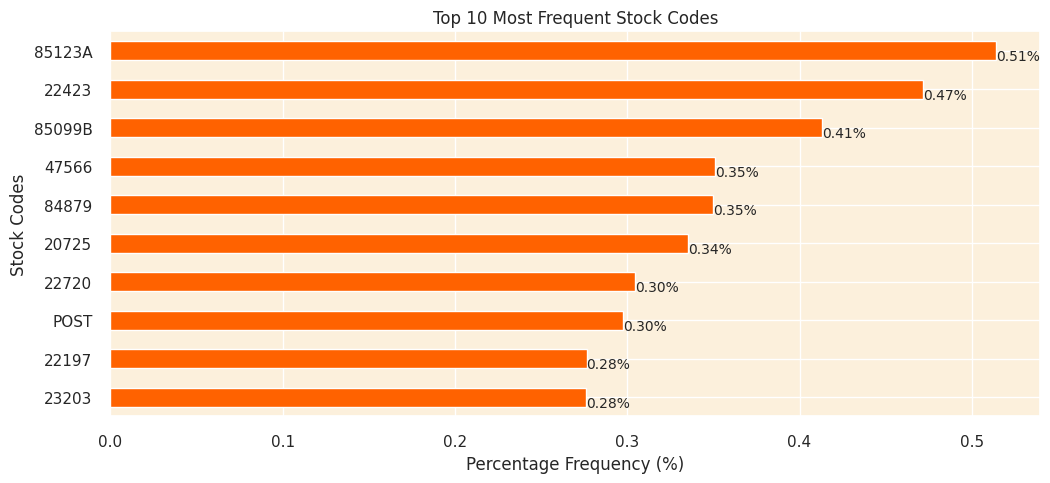

In [ ]:
# Menemukan 10 kode stok paling sering
top_10_stock_codes = df['StockCode'].value_counts(normalize=True).head(10) * 100

# Memplot 10 kode stok paling sering
plt.figure(figsize=(12, 5))
top_10_stock_codes.plot(kind='barh', color='#ff6200')

# Menambahkan frekuensi persentase pada batang
for index, value in enumerate(top_10_stock_codes):
    plt.text(value, index+0.25, f'{value:.2f}%', fontsize=10)

plt.title('Top 10 Most Frequent Stock Codes')
plt.xlabel('Percentage Frequency (%)')
plt.ylabel('Stock Codes')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Menemukan jumlah karakter numerik dalam setiap kode stok yang unik
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()

# Mencetak jumlah nilai untuk kode stok yang unik
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       7
1       1
Name: count, dtype: int64


In [ ]:
# Menemukan dan mencetak kode stok dengan karakter numerik 0 dan 1
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Mencetak setiap kode stok pada baris baru
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
PADS
DOT
CRUK


In [ ]:
# Menghitung persentase catatan dengan kode stok ini
percentage_anomalous = (df['StockCode'].isin(anomalous_stock_codes).sum() / len(df)) * 100

# Mencetak persentasenya
print(f"The percentage of records with anomalous stock codes in the dataset is: {percentage_anomalous:.2f}%")

The percentage of records with anomalous stock codes in the dataset is: 0.48%


In [ ]:
# Menghapus baris dengan kode stok anomali dari dataset
df = df[~df['StockCode'].isin(anomalous_stock_codes)]

In [ ]:
# Mendapatkan jumlah baris dalam kerangka data
df.shape[0]

399689

Step 3.5 Cleaning Description Column

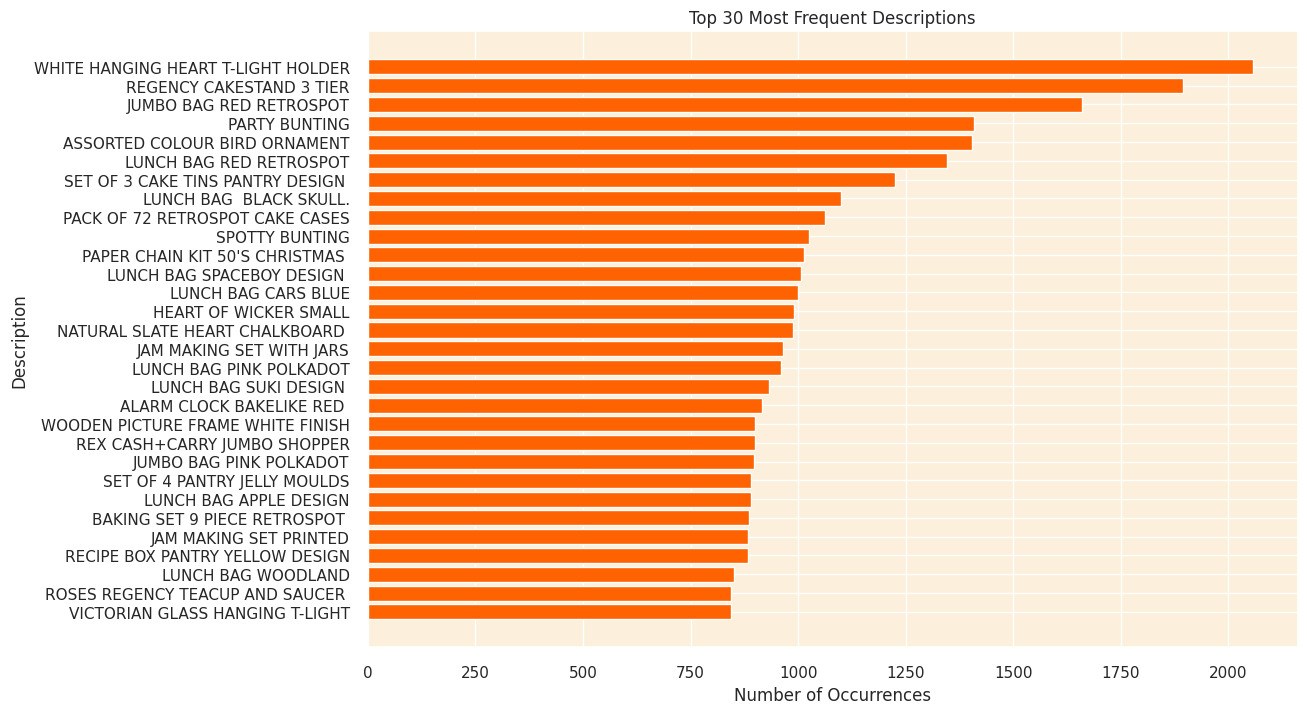

In [ ]:
# Hitung kemunculan setiap deskripsi unik dan urutkan
description_counts = df['Description'].value_counts()

# Mendapatkan 30 deskripsi teratas
top_30_descriptions = description_counts[:30]

# Plotting
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Menambahkan label dan judul
plt.xlabel('Number of Occurrences')
plt.ylabel('Description')
plt.title('Top 30 Most Frequent Descriptions')

# Menampilkan plot
plt.show()

In [ ]:
# Menemukan deskripsi unik yang berisi karakter huruf kecil
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Mencetak deskripsi unik yang berisi karakter huruf kecil
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


In [ ]:
service_related_descriptions = ["Next Day Carriage", "High Resolution Image"]

# Hitung persentase catatan dengan deskripsi terkait layanan
service_related_percentage = df[df['Description'].isin(service_related_descriptions)].shape[0] / df.shape[0] * 100

# Cetak persentase catatan dengan deskripsi terkait layanan
print(f"The percentage of records with service-related descriptions in the dataset is: {service_related_percentage:.2f}%")

# Hapus baris dengan informasi terkait layanan dalam deskripsi
df = df[~df['Description'].isin(service_related_descriptions)]

# Standarisasi teks menjadi huruf besar untuk menjaga keseragaman di seluruh kumpulan data
df['Description'] = df['Description'].str.upper()

The percentage of records with service-related descriptions in the dataset is: 0.02%


In [ ]:
# Mendapatkan jumlah baris dalam kerangka data
df.shape[0]

399606

Step 3.6 Treating Zero Unit Prices

In [ ]:
df['UnitPrice'].describe()

,UnitPrice
count,399606.000000
mean,2.904957
std,4.448796
min,0.000000
25%,1.250000
50%,1.950000
75%,3.750000
max,649.500000


In [ ]:
df[df['UnitPrice']==0].describe()[['Quantity']]

,Quantity
count,33.000000
mean,420.515152
std,2176.713608
min,1.000000
25%,2.000000
50%,11.000000
75%,36.000000
max,12540.000000


In [ ]:
# Menghapus catatan dengan harga satuan nol untuk menghindari potensi kesalahan entri data
df = df[df['UnitPrice'] > 0]

Step 3.7 Outlier Treatment

In [ ]:
# Mengatur ulang indeks dataset yang telah dibersihkan
df.reset_index(drop=True, inplace=True)

In [ ]:
# Mendapatkan jumlah baris dalam kerangka data
df.shape[0]

399573

**Step 4 Feature Engineering**

Step 4.1 RFM Features

Step 4.1.1 Recency (R)

In [ ]:
# Ubah InvoiceDate menjadi tipe datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Konversi InvoiceDate ke datetime dan ekstrak hanya tanggalnya
df['InvoiceDay'] = df['InvoiceDate'].dt.date

# Temukan tanggal pembelian terbaru untuk setiap pelanggan
customer_data = df.groupby('CustomerID')['InvoiceDay'].max().reset_index()

# Temukan tanggal terbaru di seluruh kumpulan data
most_recent_date = df['InvoiceDay'].max()

# Ubah InvoiceDay menjadi tipe datetime sebelum pengurangan
customer_data['InvoiceDay'] = pd.to_datetime(customer_data['InvoiceDay'])
most_recent_date = pd.to_datetime(most_recent_date)

# Hitung jumlah hari sejak pembelian terakhir untuk setiap pelanggan
customer_data['Days_Since_Last_Purchase'] = (most_recent_date - customer_data['InvoiceDay']).dt.days

# Hapus kolom InvoiceDay
customer_data.drop(columns=['InvoiceDay'], inplace=True)


In [ ]:
customer_data.head()

,CustomerID,Days_Since_Last_Purchase
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310


Step 4.1.2 Frequency (F)

In [ ]:
# Hitung jumlah total transaksi yang dilakukan oleh setiap pelanggan
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
total_transactions.rename(columns={'InvoiceNo': 'Total_Transactions'}, inplace=True)

# Hitung jumlah total produk yang dibeli oleh setiap pelanggan
total_products_purchased = df.groupby('CustomerID')['Quantity'].sum().reset_index()
total_products_purchased.rename(columns={'Quantity': 'Total_Products_Purchased'}, inplace=True)

# Gabungkan fitur-fitur baru ke dalam kerangka data customer_data
customer_data = pd.merge(customer_data, total_transactions, on='CustomerID')
customer_data = pd.merge(customer_data, total_products_purchased, on='CustomerID')

# Menampilkan beberapa baris pertama kerangka data customer_data
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased
0,12346.0,325,2,0
1,12347.0,2,7,2458
2,12348.0,75,4,2332
3,12349.0,18,1,630
4,12350.0,310,1,196


Step 4.1.3 Monetary (M)

In [ ]:
# Hitung total pengeluaran setiap pelanggan
df['Total_Spend'] = df['UnitPrice'] * df['Quantity']
total_spend = df.groupby('CustomerID')['Total_Spend'].sum().reset_index()

# Hitung nilai transaksi rata-rata untuk setiap pelanggan
average_transaction_value = total_spend.merge(total_transactions, on='CustomerID')
average_transaction_value['Average_Transaction_Value'] = average_transaction_value['Total_Spend'] / average_transaction_value['Total_Transactions']

# Gabungkan fitur-fitur baru ke dalam kerangka data customer_data
customer_data = pd.merge(customer_data, total_spend, on='CustomerID')
customer_data = pd.merge(customer_data, average_transaction_value[['CustomerID', 'Average_Transaction_Value']], on='CustomerID')

# Menampilkan beberapa baris pertama kerangka data customer_data
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value
0,12346.0,325,2,0,0.00,0.000000
1,12347.0,2,7,2458,4310.00,615.714286
2,12348.0,75,4,2332,1437.24,359.310000
3,12349.0,18,1,630,1457.55,1457.550000
4,12350.0,310,1,196,294.40,294.400000


Step 4.2 Product Diversity

In [ ]:
# Hitung jumlah produk unik yang dibeli oleh setiap pelanggan
unique_products_purchased = df.groupby('CustomerID')['StockCode'].nunique().reset_index()
unique_products_purchased.rename(columns={'StockCode': 'Unique_Products_Purchased'}, inplace=True)

# Gabungkan fitur baru ke dalam kerangka data customer_data
customer_data = pd.merge(customer_data, unique_products_purchased, on='CustomerID')

# Menampilkan beberapa baris pertama kerangka data customer_data
customer_data.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased
0,12346.0,325,2,0,0.00,0.000000,1
1,12347.0,2,7,2458,4310.00,615.714286,103
2,12348.0,75,4,2332,1437.24,359.310000,21
3,12349.0,18,1,630,1457.55,1457.550000,72
4,12350.0,310,1,196,294.40,294.400000,16


In [ ]:
# Ekstrak hari dalam seminggu dan jam dari InvoiceDate
df['Day_Of_Week'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

# Hitung rata-rata jumlah hari antara pembelian berturut-turut
days_between_purchases = df.groupby('CustomerID')['InvoiceDay'].apply(lambda x: (x.diff().dropna()).apply(lambda y: y.days))
average_days_between_purchases = days_between_purchases.groupby('CustomerID').mean().reset_index()
average_days_between_purchases.rename(columns={'InvoiceDay': 'Average_Days_Between_Purchases'}, inplace=True)

# Temukan hari belanja favorit dalam seminggu
favorite_shopping_day = df.groupby(['CustomerID', 'Day_Of_Week']).size().reset_index(name='Count')
favorite_shopping_day = favorite_shopping_day.loc[favorite_shopping_day.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Day_Of_Week']]

# Temukan jam belanja favorit hari ini
favorite_shopping_hour = df.groupby(['CustomerID', 'Hour']).size().reset_index(name='Count')
favorite_shopping_hour = favorite_shopping_hour.loc[favorite_shopping_hour.groupby('CustomerID')['Count'].idxmax()][['CustomerID', 'Hour']]

# Gabungkan fitur-fitur baru ke dalam kerangka data customer_data
customer_data = pd.merge(customer_data, average_days_between_purchases, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_day, on='CustomerID')
customer_data = pd.merge(customer_data, favorite_shopping_hour, on='CustomerID')

# Menampilkan beberapa baris pertama kerangka data customer_data
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16


Step 4.4 Geographic Features

In [ ]:
df['Country'].value_counts(normalize=True).head()

,proportion
Country,
United Kingdom,0.890971
Germany,0.022722
France,0.020402
EIRE,0.018440
Spain,0.006162


In [ ]:
# Kelompokkan berdasarkan ID Pelanggan dan Negara untuk mendapatkan jumlah transaksi per negara untuk setiap pelanggan
customer_country = df.groupby(['CustomerID', 'Country']).size().reset_index(name='Number_of_Transactions')

# Dapatkan negara dengan jumlah transaksi maksimum untuk setiap pelanggan (jika pelanggan memiliki transaksi dari beberapa negara)
customer_main_country = customer_country.sort_values('Number_of_Transactions', ascending=False).drop_duplicates('CustomerID')

# Buat kolom biner yang menunjukkan apakah pelanggan berasal dari Inggris atau bukan
customer_main_country['Is_UK'] = customer_main_country['Country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

# Gabungkan data ini dengan kerangka data customer_data kita
customer_data = pd.merge(customer_data, customer_main_country[['CustomerID', 'Is_UK']], on='CustomerID', how='left')

# Menampilkan beberapa baris pertama kerangka data customer_data
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0


In [ ]:
# Distribusi fitur tampilan
customer_data['Is_UK'].value_counts()

,count
Is_UK,
1,3866
0,416


Step 4.5 Cancellation Inshights

In [ ]:
# Hitung jumlah total transaksi yang dilakukan oleh setiap pelanggan
total_transactions = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()

# Hitung jumlah transaksi yang dibatalkan untuk setiap pelanggan
cancelled_transactions = df[df['Transaction_Status'] == 'Cancelled']
cancellation_frequency = cancelled_transactions.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
cancellation_frequency.rename(columns={'InvoiceNo': 'Cancellation_Frequency'}, inplace=True)

# Gabungkan data Frekuensi Pembatalan ke dalam kerangka data customer_data
customer_data = pd.merge(customer_data, cancellation_frequency, on='CustomerID', how='left')

# Ganti nilai NaN dengan 0 (untuk pelanggan yang belum membatalkan transaksi apa pun)
customer_data['Cancellation_Frequency'].fillna(0, inplace=True)

# Hitung Tingkat Pembatalan
customer_data['Cancellation_Rate'] = customer_data['Cancellation_Frequency'] / total_transactions['InvoiceNo']

# Menampilkan beberapa baris pertama kerangka data customer_data
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0


Step 4.6 Seasonality & Trends

In [ ]:
# Ekstrak bulan dan tahun dari InvoiceDate
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month

# Hitung pengeluaran bulanan untuk setiap pelanggan
monthly_spending = df.groupby(['CustomerID', 'Year', 'Month'])['Total_Spend'].sum().reset_index()

# Hitung Pola Pembelian Musiman: Kami menggunakan frekuensi bulanan sebagai proksi untuk pola pembelian musiman
seasonal_buying_patterns = monthly_spending.groupby('CustomerID')['Total_Spend'].agg(['mean', 'std']).reset_index()
seasonal_buying_patterns.rename(columns={'mean': 'Monthly_Spending_Mean', 'std': 'Monthly_Spending_Std'}, inplace=True)

# Ganti nilai NaN di Monthly_Spending_Std dengan 0, yang berarti tidak ada variabilitas untuk pelanggan dengan bulan transaksi tunggal
seasonal_buying_patterns['Monthly_Spending_Std'].fillna(0, inplace=True)

# Hitung Tren Pengeluaran
# Kami menggunakan kemiringan garis tren linier yang disesuaikan dengan pengeluaran pelanggan dari waktu ke waktu sebagai indikator tren pengeluaran.
def calculate_trend(spend_data):
    # Jika terdapat lebih dari satu titik data, kita hitung trennya menggunakan regresi linier
    if len(spend_data) > 1:
        x = np.arange(len(spend_data))
        slope, _, _, _, _ = linregress(x, spend_data)
        return slope
    # Jika hanya ada satu titik data, tidak ada tren yang dapat dihitung, maka kita mengembalikan 0
    else:
        return 0

# Terapkan fungsi calculate_trend untuk menemukan tren pengeluaran untuk setiap pelanggan
spending_trends = monthly_spending.groupby('CustomerID')['Total_Spend'].apply(calculate_trend).reset_index()
spending_trends.rename(columns={'Total_Spend': 'Spending_Trend'}, inplace=True)

# Gabungkan fitur-fitur baru ke dalam kerangka data customer_data
customer_data = pd.merge(customer_data, seasonal_buying_patterns, on='CustomerID')
customer_data = pd.merge(customer_data, spending_trends, on='CustomerID')

# Menampilkan beberapa baris pertama kerangka data customer_data
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,0.000000
1,12347.0,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-100.884000
3,12349.0,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,0.000000
4,12350.0,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,0.000000


In [ ]:
# Mengubah tipe data 'CustomerID' menjadi string karena merupakan pengenal unik dan tidak digunakan dalam operasi matematika
customer_data['CustomerID'] = customer_data['CustomerID'].astype(str)

# Mengonversi tipe data kolom ke tipe optimal
customer_data = customer_data.convert_dtypes()

In [ ]:
customer_data.head(10)

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0
5,12352.0,36,8,463,1265.41,158.17625,57,3.13253,1,14,0,1,0.125,316.3525,134.700629,9.351
6,12353.0,204,1,20,89.0,89.0,4,0.0,3,17,0,0,0.0,89.0,0.0,0.0
7,12354.0,232,1,530,1079.4,1079.4,58,0.0,3,13,0,0,0.0,1079.4,0.0,0.0
8,12355.0,214,1,240,459.4,459.4,13,0.0,0,13,0,0,0.0,459.4,0.0,0.0
9,12356.0,22,3,1573,2487.43,829.143333,52,5.315789,1,9,0,0,0.0,829.143333,991.462585,-944.635


In [ ]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4282 entries, 0 to 4281
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   CustomerID                      4282 non-null   string 
 1   Days_Since_Last_Purchase        4282 non-null   Int64  
 2   Total_Transactions              4282 non-null   Int64  
 3   Total_Products_Purchased        4282 non-null   Int64  
 4   Total_Spend                     4282 non-null   Float64
 5   Average_Transaction_Value       4282 non-null   Float64
 6   Unique_Products_Purchased       4282 non-null   Int64  
 7   Average_Days_Between_Purchases  4282 non-null   Float64
 8   Day_Of_Week                     4282 non-null   Int32  
 9   Hour                            4282 non-null   Int32  
 10  Is_UK                           4282 non-null   Int64  
 11  Cancellation_Frequency          4282 non-null   Int64  
 12  Cancellation_Rate               42

**Step 5 Outlier Detection and Treatment**

In [ ]:
# Inisialisasi model IsolationForest dengan parameter kontaminasi 0,05
model = IsolationForest(contamination=0.05, random_state=0)

# Menyesuaikan model pada dataset kita (mengonversi DataFrame ke NumPy untuk menghindari peringatan)
customer_data['Outlier_Scores'] = model.fit_predict(customer_data.iloc[:, 1:].to_numpy())

# Membuat kolom baru untuk mengidentifikasi outlier (1 untuk inlier dan -1 untuk outlier)
customer_data['Is_Outlier'] = [1 if x == -1 else 0 for x in customer_data['Outlier_Scores']]

# Menampilkan beberapa baris pertama kerangka data customer_data
customer_data.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,Outlier_Scores,Is_Outlier
0,12346.0,325,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,1,0
1,12347.0,2,7,2458,4310.0,615.714286,103,2.016575,1,14,0,0,0.0,615.714286,341.070789,4.486071,1,0
2,12348.0,75,4,2332,1437.24,359.31,21,10.884615,3,19,0,0,0.0,359.31,203.875689,-100.884,1,0
3,12349.0,18,1,630,1457.55,1457.55,72,0.0,0,9,0,0,0.0,1457.55,0.0,0.0,1,0
4,12350.0,310,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,1,0


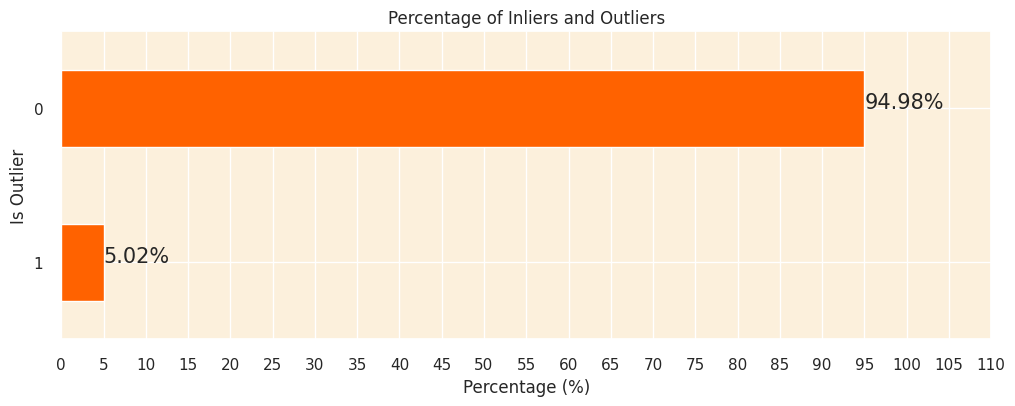

In [ ]:
# Hitung persentase inlier dan outlier
outlier_percentage = customer_data['Is_Outlier'].value_counts(normalize=True) * 100

# Memplot persentase inlier dan outlier
plt.figure(figsize=(12, 4))
outlier_percentage.plot(kind='barh', color='#ff6200')

# Menambahkan label persentase pada batang
for index, value in enumerate(outlier_percentage):
    plt.text(value, index, f'{value:.2f}%', fontsize=15)

plt.title('Percentage of Inliers and Outliers')
plt.xticks(ticks=np.arange(0, 115, 5))
plt.xlabel('Percentage (%)')
plt.ylabel('Is Outlier')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
# Pisahkan outlier untuk analisis
outliers_data = customer_data[customer_data['Is_Outlier'] == 1]

# Hapus outlier dari dataset utama
customer_data_cleaned = customer_data[customer_data['Is_Outlier'] == 0]

# Hapus kolom 'Outlier_Scores' dan 'Is_Outlier'
customer_data_cleaned = customer_data_cleaned.drop(columns=['Outlier_Scores', 'Is_Outlier'])

# Setel ulang indeks data yang dibersihkan
customer_data_cleaned.reset_index(drop=True, inplace=True)

In [ ]:
# Mendapatkan jumlah baris dalam kumpulan data pelanggan yang dibersihkan
customer_data_cleaned.shape[0]

4067

**Step 6 Correlation Analysis**

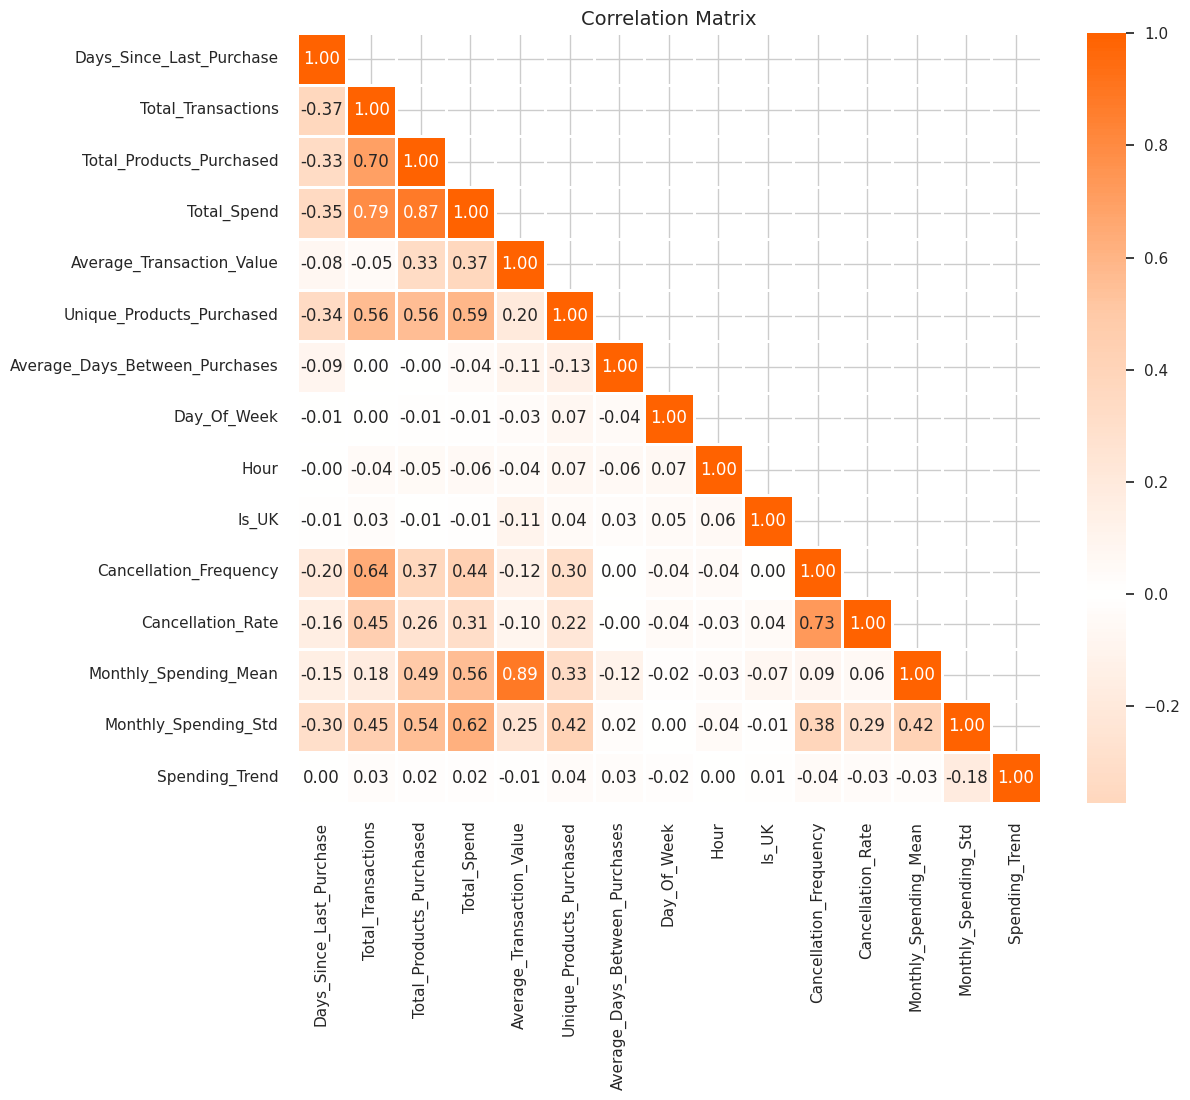

In [ ]:
# Setel ulang gaya latar belakang
sns.set_style('whitegrid')

# Hitung matriks korelasi tanpa kolom 'CustomerID'
corr = customer_data_cleaned.drop(columns=['CustomerID']).corr()

# Tentukan peta warna khusus
colors = ['#ff6200', '#ffcaa8', 'white', '#ffcaa8', '#ff6200']
my_cmap = LinearSegmentedColormap.from_list('custom_map', colors, N=256)

# Buat topeng untuk hanya menampilkan segitiga bawah matriks (karena dicerminkan di sekitar segitiga bawah matriks).
# (diagonal kiri atas ke kanan bawah)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k=1)] = True

# Plot peta panasnya
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap=my_cmap, annot=True, center=0, fmt='.2f', linewidths=2)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

**Step 7 Feature Scaling**

In [ ]:
# Inisialisasi StandardScaler
scaler = StandardScaler()

# Daftar kolom yang tidak perlu diskalakan
columns_to_exclude = ['CustomerID', 'Is_UK', 'Day_Of_Week']

# Daftar kolom yang perlu diskalakan
columns_to_scale = customer_data_cleaned.columns.difference(columns_to_exclude)

# Salin dataset yang telah dibersihkan
customer_data_scaled = customer_data_cleaned.copy()

# Menerapkan scaler ke kolom yang diperlukan dalam dataset
customer_data_scaled[columns_to_scale] = scaler.fit_transform(customer_data_scaled[columns_to_scale])

# Menampilkan beberapa baris pertama dari data berskala
customer_data_scaled.head()


,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend
0,12346.0,2.345802,-0.477589,-0.754491,-0.813464,-1.317106,-0.908471,-0.310564,1,-1.086929,1,0.420541,0.417623,-1.329018,-0.713318,0.090868
1,12347.0,-0.905575,0.707930,2.005048,2.366920,1.528132,0.815119,-0.128438,1,0.647126,0,-0.545753,-0.432111,0.989511,1.259961,0.116774
2,12348.0,-0.170744,-0.003381,1.863591,0.247087,0.343279,-0.570512,0.672476,3,2.814696,0,-0.545753,-0.432111,0.023997,0.466213,-0.491708
3,12349.0,-0.744516,-0.714692,-0.047205,0.262074,5.418285,0.291283,-0.310564,0,-1.520443,0,-0.545753,-0.432111,4.159521,-0.713318,0.090868
4,12350.0,2.194809,-0.714692,-0.534446,-0.596223,0.043327,-0.655002,-0.310564,2,1.514154,0,-0.545753,-0.432111,-0.220428,-0.713318,0.090868


**Step 8 Dimensionality Reduction**

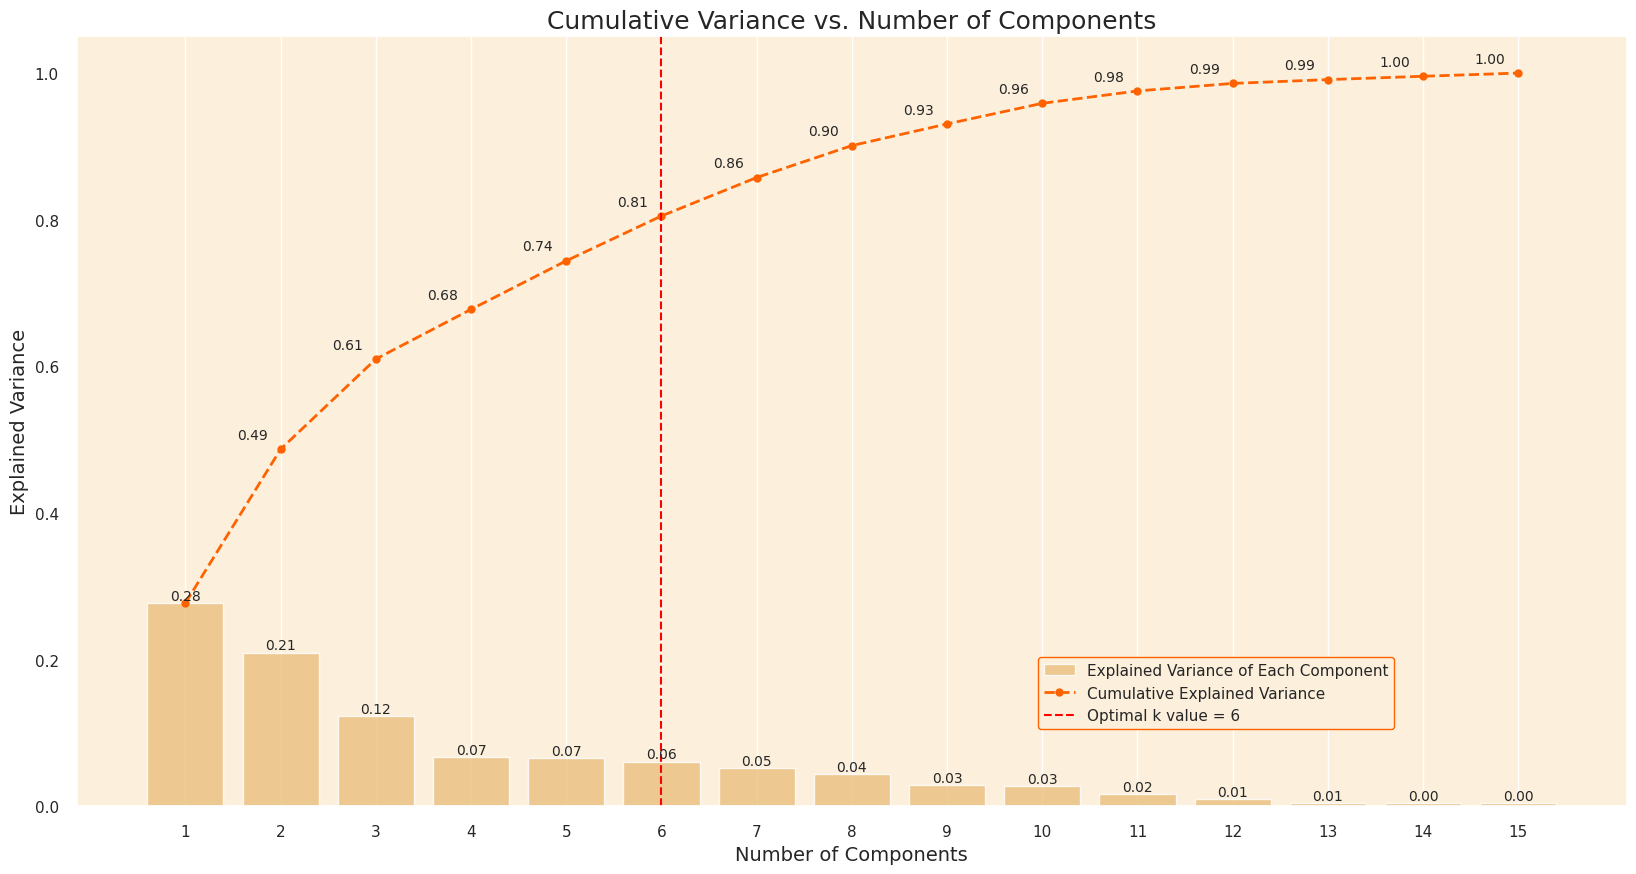

In [ ]:
# Menetapkan CustomerID sebagai kolom indeks
customer_data_scaled.set_index('CustomerID', inplace=True)

# Terapkan PCA
pca = PCA().fit(customer_data_scaled)

# Hitung Jumlah Kumulatif Varians yang Dijelaskan
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Tetapkan nilai k optimal (berdasarkan analisis kami, kami dapat memilih 6)
optimal_k = 6

# Tetapkan gaya plot seaborn
sns.set(rc={'axes.facecolor': '#fcf0dc'}, style='darkgrid')

# Plotkan varians kumulatif yang dijelaskan terhadap jumlah komponen
plt.figure(figsize=(20, 10))

# Bagan batang untuk varians yang dijelaskan dari setiap komponen
barplot = sns.barplot(x=list(range(1, len(cumulative_explained_variance) + 1)),
                      y=explained_variance_ratio,
                      color='#fcc36d',
                      alpha=0.8)

# Plot garis untuk varians kumulatif yang dijelaskan
lineplot, = plt.plot(range(0, len(cumulative_explained_variance)), cumulative_explained_variance,
                     marker='o', linestyle='--', color='#ff6200', linewidth=2)

# Gambarkan garis nilai k optimal
optimal_k_line = plt.axvline(optimal_k - 1, color='red', linestyle='--', label=f'Optimal k value = {optimal_k}')

# Tetapkan label dan judul
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title('Cumulative Variance vs. Number of Components', fontsize=18)

# Sesuaikan tanda centang dan legenda
plt.xticks(range(0, len(cumulative_explained_variance)))
plt.legend(handles=[barplot.patches[0], lineplot, optimal_k_line],
           labels=['Explained Variance of Each Component', 'Cumulative Explained Variance', f'Optimal k value = {optimal_k}'],
           loc=(0.62, 0.1),
           frameon=True,
           framealpha=1.0,
           edgecolor='#ff6200')

# Menampilkan nilai varians untuk kedua grafik pada plot
x_offset = -0.3
y_offset = 0.01
for i, (ev_ratio, cum_ev_ratio) in enumerate(zip(explained_variance_ratio, cumulative_explained_variance)):
    plt.text(i, ev_ratio, f"{ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)
    if i > 0:
        plt.text(i + x_offset, cum_ev_ratio + y_offset, f"{cum_ev_ratio:.2f}", ha="center", va="bottom", fontsize=10)

plt.grid(axis='both')
plt.show()


In [ ]:
# Membuat objek PCA dengan 6 komponen
pca = PCA(n_components=6)

# Pemasangan dan transformasi data asli ke kerangka data PCA baru
customer_data_pca = pca.fit_transform(customer_data_scaled)

# Membuat kerangka data baru dari kerangka data PCA, dengan kolom berlabel PC1, PC2, dst.
customer_data_pca = pd.DataFrame(customer_data_pca, columns=['PC'+str(i+1) for i in range(pca.n_components_)])

# Menambahkan indeks CustomerID kembali ke kerangka data PCA baru
customer_data_pca.index = customer_data_scaled.index

In [ ]:
# Menampilkan kerangka data yang dihasilkan berdasarkan PC
customer_data_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
CustomerID,,,,,,
12346.0,-2.186469,-1.705370,-1.576745,-1.008187,-0.411803,-1.658012
12347.0,3.290264,-1.387375,1.923310,0.930990,-0.010591,0.873150
12348.0,0.584684,0.585019,0.664727,0.655411,-0.470280,2.306657
12349.0,1.791116,-2.695652,5.850040,-0.853418,0.677111,-1.520098
12350.0,-1.997139,-0.542639,0.578781,-0.183682,-1.484838,0.062672


In [ ]:
# Tentukan fungsi untuk menyorot 3 nilai absolut teratas di setiap kolom kerangka data
def highlight_top3(column):
    top3 = column.abs().nlargest(3).index
    return ['background-color:  #ffeacc' if i in top3 else '' for i in column.index]

# Buat komponen PCA DataFrame dan terapkan fungsi penyorotan
pc_df = pd.DataFrame(pca.components_.T, columns=['PC{}'.format(i+1) for i in range(pca.n_components_)],
                     index=customer_data_scaled.columns)

pc_df.style.apply(highlight_top3, axis=0)


,PC1,PC2,PC3,PC4,PC5,PC6
Days_Since_Last_Purchase,-0.217859,-0.013986,0.067660,-0.273430,-0.240968,-0.373059
Total_Transactions,0.380301,0.014759,-0.259180,0.138165,-0.017356,-0.028257
Total_Products_Purchased,0.401425,0.007365,0.069133,0.134806,0.057476,-0.013373
Total_Spend,0.431260,0.010159,0.065165,0.092047,0.025202,-0.036947
Average_Transaction_Value,0.176225,-0.015544,0.589050,-0.114307,0.021847,-0.101738
Unique_Products_Purchased,0.324992,0.063346,0.014010,0.230502,-0.193981,0.124604
Average_Days_Between_Purchases,-0.022600,-0.036007,-0.127341,0.160627,0.753462,0.211787
Day_Of_Week,-0.026572,0.994650,-0.006591,-0.028870,0.058359,-0.060799
Hour,-0.024259,0.056388,-0.002019,0.226832,-0.528881,0.621915
Is_UK,-0.001014,0.007435,-0.018378,0.013419,-0.005353,0.014384


**Step 9 K-Means Clustering**

Step 9.1 Determining the Optimal Number of Clusters

Step 9.1.1 Elbow Method

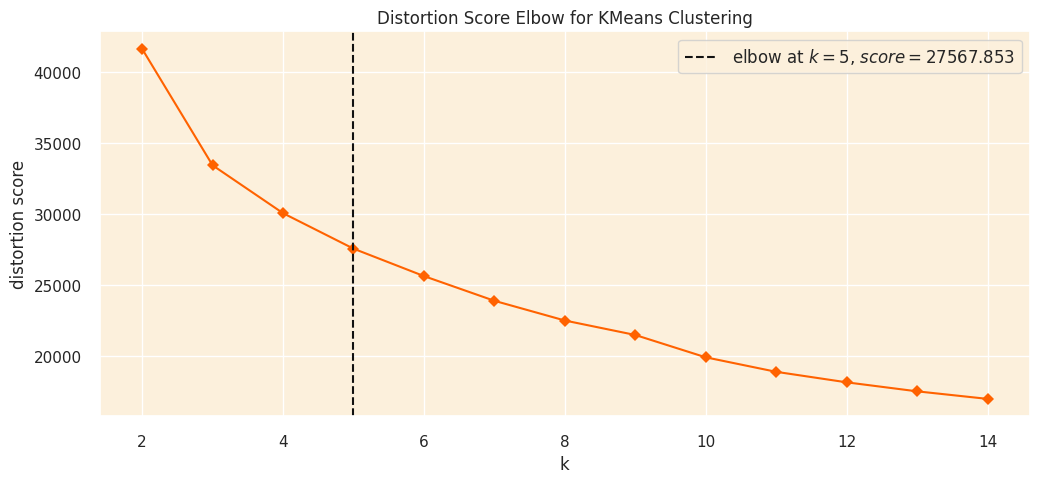

In [ ]:
# Atur gaya plot dan warna latar belakang
sns.set(style='darkgrid', rc={'axes.facecolor': '#fcf0dc'})

# Mengatur palet warna untuk plot
sns.set_palette(['#ff6200'])

# Membuat model pengelompokan dengan parameter yang ditentukan
km = KMeans(init='k-means++', n_init=10, max_iter=100, random_state=0)

# Buatlah gambar dan sumbu dengan ukuran yang diinginkan
fig, ax = plt.subplots(figsize=(12, 5))

# Buat instance KElbowVisualizer dengan model dan rentang nilai k, dan nonaktifkan plot waktu
visualizer = KElbowVisualizer(km, k=(2, 15), timings=False, ax=ax)

# Sesuaikan data dengan visualizer
visualizer.fit(customer_data_pca)

# Finalisasikan dan render gambarnya
visualizer.show();

Step 9.1.2 Silhouette Method

In [ ]:
def silhouette_analysis(df, start_k, stop_k, figsize=(15, 16)):
    """
    Perform Silhouette analysis for a range of k values and visualize the results.
    """

    # Mengatur ukuran gambar
    plt.figure(figsize=figsize)

    # Buat grid dengan (stop_k - start_k + 1) baris dan 2 kolom
    grid = gridspec.GridSpec(stop_k - start_k + 1, 2)

    # Tetapkan plot pertama ke baris pertama dan kedua kolom
    first_plot = plt.subplot(grid[0, :])

    # Plot pertama: Skor siluet untuk nilai k yang berbeda
    sns.set_palette(['darkorange'])

    silhouette_scores = []

    # Ulangi melalui rentang nilai k
    for k in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=100, random_state=0)
        km.fit(df)
        labels = km.predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)

    best_k = start_k + silhouette_scores.index(max(silhouette_scores))

    plt.plot(range(start_k, stop_k + 1), silhouette_scores, marker='o')
    plt.xticks(range(start_k, stop_k + 1))
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette score')
    plt.title('Average Silhouette Score for Different k Values', fontsize=15)

    # Tambahkan teks nilai k optimal ke plot
    optimal_k_text = f'The k value with the highest Silhouette score is: {best_k}'
    plt.text(10, 0.23, optimal_k_text, fontsize=12, verticalalignment='bottom',
             horizontalalignment='left', bbox=dict(facecolor='#fcc36d', edgecolor='#ff6200', boxstyle='round, pad=0.5'))


    # Plot kedua (subplot): Plot siluet untuk setiap nilai k
    colors = sns.color_palette("bright")

    for i in range(start_k, stop_k + 1):
        km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=0)
        row_idx, col_idx = divmod(i - start_k, 2)

        # Tetapkan plot ke baris kedua, ketiga, dan keempat
        ax = plt.subplot(grid[row_idx + 1, col_idx])

        visualizer = SilhouetteVisualizer(km, colors=colors, ax=ax)
        visualizer.fit(df)

        # Tambahkan teks skor Silhouette ke plot
        score = silhouette_score(df, km.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='red')

        ax.set_title(f'Silhouette Plot for {i} Clusters', fontsize=15)

    plt.tight_layout()
    plt.show()


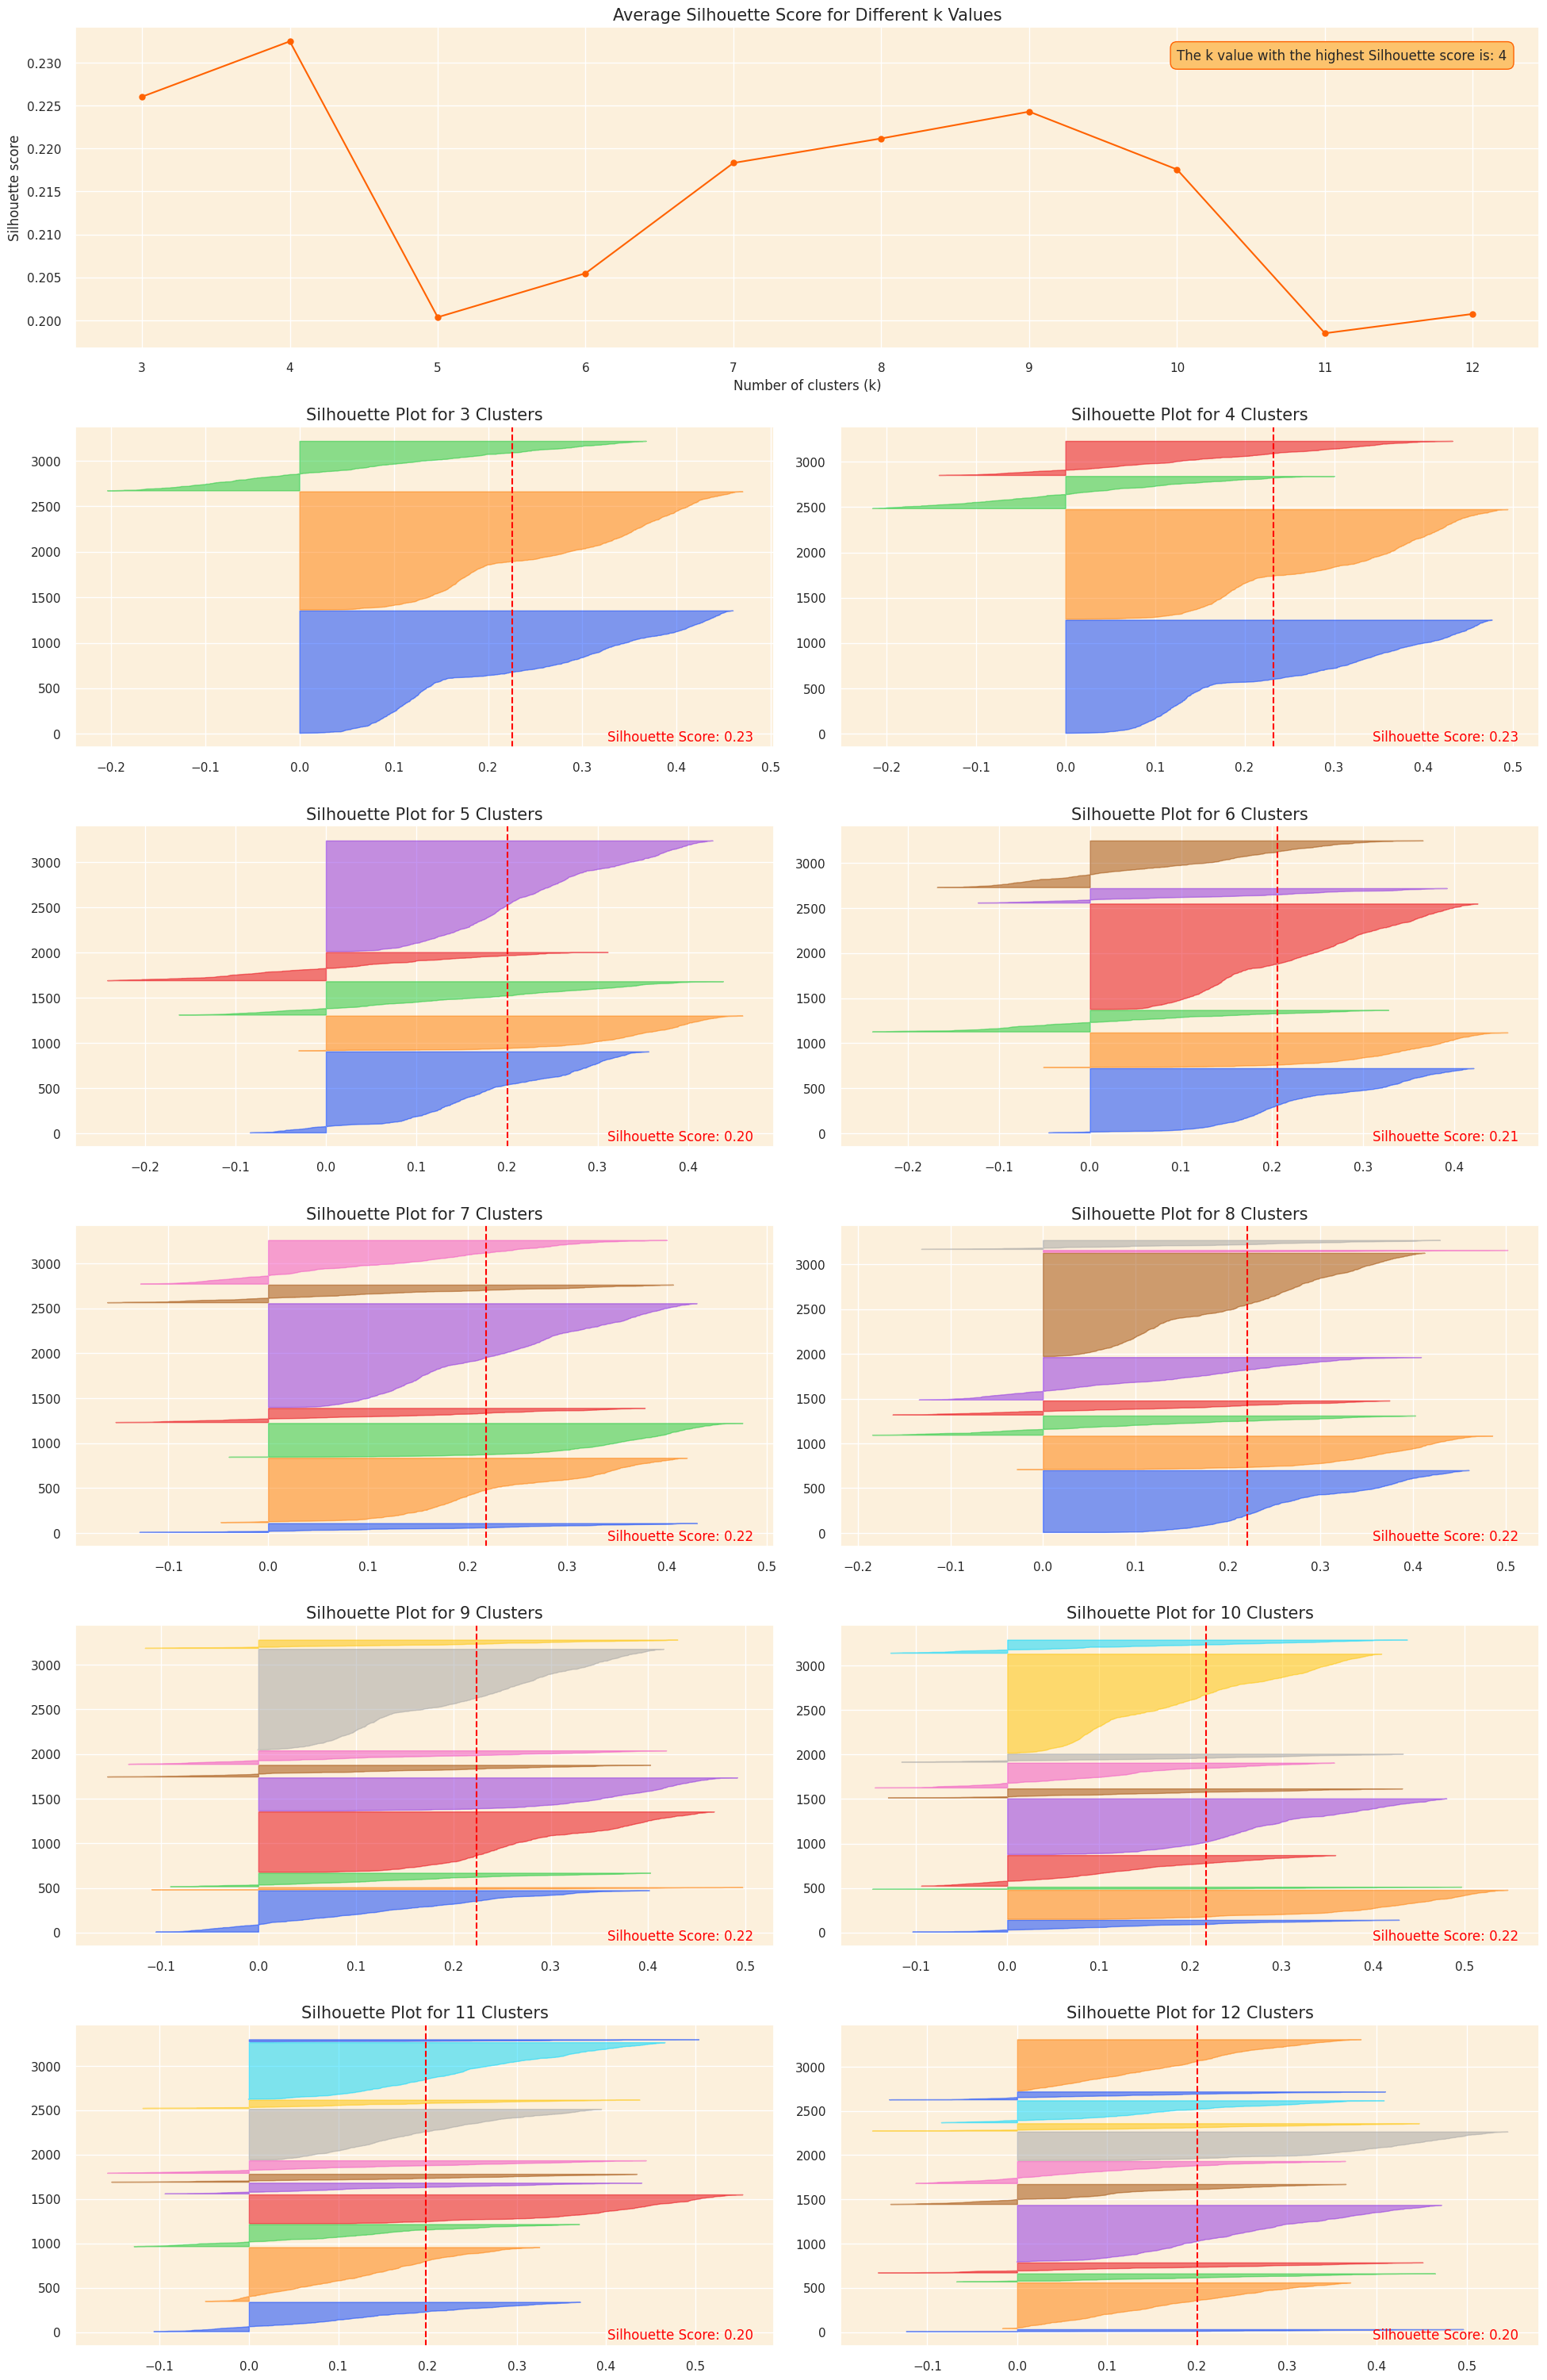

In [ ]:
silhouette_analysis(customer_data_pca, 3, 12, figsize=(20, 50))

Step 9.2 Clustering Model K-means

In [ ]:
# Terapkan pengelompokan KMeans menggunakan k optimal
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=100, random_state=0)
kmeans.fit(customer_data_pca)

# Dapatkan frekuensi setiap cluster
cluster_frequencies = Counter(kmeans.labels_)

# Buat pemetaan dari label lama ke label baru berdasarkan frekuensi
label_mapping = {label: new_label for new_label, (label, _) in
                 enumerate(cluster_frequencies.most_common())}

# Membalikkan pemetaan untuk menetapkan label sesuai kriteria Anda
label_mapping = {v: k for k, v in {2: 1, 1: 0, 0: 2}.items()}

# Terapkan pemetaan untuk mendapatkan label baru
new_labels = np.array([label_mapping[label] for label in kmeans.labels_])

# Tambahkan label cluster baru kembali ke dataset asli
customer_data_cleaned['cluster'] = new_labels

# Tambahkan label klaster baru ke versi PCA dari dataset
customer_data_pca['cluster'] = new_labels

In [ ]:
# Menampilkan beberapa baris pertama dari kerangka data asli
customer_data_cleaned.head()

,CustomerID,Days_Since_Last_Purchase,Total_Transactions,Total_Products_Purchased,Total_Spend,Average_Transaction_Value,Unique_Products_Purchased,Average_Days_Between_Purchases,Day_Of_Week,Hour,Is_UK,Cancellation_Frequency,Cancellation_Rate,Monthly_Spending_Mean,Monthly_Spending_Std,Spending_Trend,cluster
0,12346.0,238,2,0,0.0,0.0,1,0.0,1,10,1,1,0.5,0.0,0.0,0.0,2
1,12347.0,42,5,1590,2790.86,558.172,82,1.934959,1,14,0,0,0.0,558.172,130.495277,-34.663,0
2,12348.0,161,3,2116,1167.24,389.08,21,4.583333,3,19,0,0,0.0,389.08,238.810442,-162.9,1
3,12350.0,223,1,196,294.4,294.4,16,0.0,2,16,0,0,0.0,294.4,0.0,0.0,2
4,12352.0,175,5,186,521.18,104.236,24,0.871795,1,16,0,1,0.2,260.59,50.784409,-71.82,2


**Step 10 Clustering Evaluation**

Step 10.1 3D Visualization to Top Principal Components

In [ ]:
!pip install plotly==5.18.0
import plotly.io as pio
pio.renderers.default = 'colab'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.6/15.6 MB 67.1 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [ ]:
# Menetapkan skema warna untuk cluster (urutan RGB)
colors = ['#e8000b', '#1ac938', '#023eff']

In [ ]:
# Buat bingkai data terpisah untuk setiap kluster
cluster_0 = customer_data_pca[customer_data_pca['cluster'] == 0]
cluster_1 = customer_data_pca[customer_data_pca['cluster'] == 1]
cluster_2 = customer_data_pca[customer_data_pca['cluster'] == 2]


# Membuat diagram sebaran 3D
fig = go.Figure()

# Tambahkan titik data untuk setiap cluster secara terpisah dan tentukan warnanya
fig.add_trace(go.Scatter3d(x=cluster_0['PC1'], y=cluster_0['PC2'], z=cluster_0['PC3'],
                           mode='markers', marker=dict(color=colors[0], size=5, opacity=0.4), name='Cluster 0'))
fig.add_trace(go.Scatter3d(x=cluster_1['PC1'], y=cluster_1['PC2'], z=cluster_1['PC3'],
                           mode='markers', marker=dict(color=colors[1], size=5, opacity=0.4), name='Cluster 1'))
fig.add_trace(go.Scatter3d(x=cluster_2['PC1'], y=cluster_2['PC2'], z=cluster_2['PC3'],
                           mode='markers', marker=dict(color=colors[2], size=5, opacity=0.4), name='Cluster 2'))

# Tetapkan judul dan detail tata letak
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Tunjukkan alur ceritanya
fig.show()

Step 10.2 Cluster Distribution Visualization

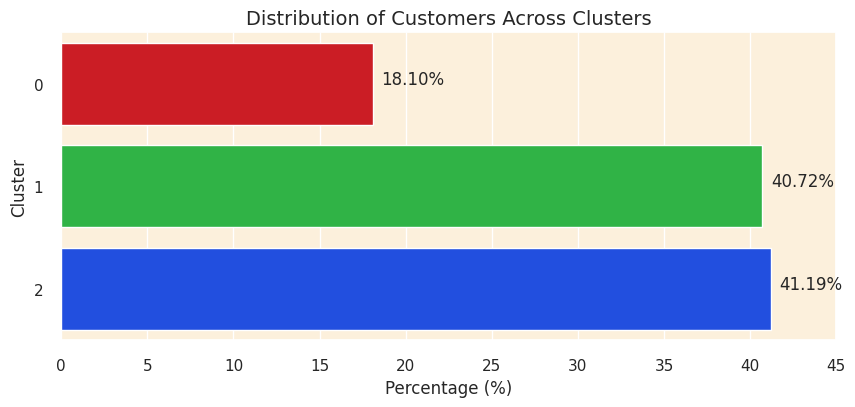

In [ ]:
# Menghitung persentase pelanggan di setiap cluster
cluster_percentage = (customer_data_pca['cluster'].value_counts(normalize=True) * 100).reset_index()
cluster_percentage.columns = ['Cluster', 'Percentage']
cluster_percentage.sort_values(by='Cluster', inplace=True)

# Membuat diagram batang horizontal
plt.figure(figsize=(10, 4))
sns.barplot(x='Percentage', y='Cluster', data=cluster_percentage, orient='h', palette=colors)

# Menambahkan persentase pada batang
for index, value in enumerate(cluster_percentage['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Distribution of Customers Across Clusters', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Tunjukkan alur ceritanya
plt.show()

Step  10.3 Evaluation Metrics

In [ ]:
# Hitung jumlah pelanggan
num_observations = len(customer_data_pca)

# Pisahkan fitur dan label cluster
X = customer_data_pca.drop('cluster', axis=1)
clusters = customer_data_pca['cluster']

# Hitung metriknya
sil_score = silhouette_score(X, clusters)
calinski_score = calinski_harabasz_score(X, clusters)
davies_score = davies_bouldin_score(X, clusters)

# Buat tabel untuk menampilkan metrik dan jumlah observasi
table_data = [
    ["Number of Observations", num_observations],
    ["Silhouette Score", sil_score],
    ["Calinski Harabasz Score", calinski_score],
    ["Davies Bouldin Score", davies_score]
]

# Cetak tabelnya
print(tabulate(table_data, headers=["Metric", "Value"], tablefmt='pretty'))

+-------------------------+---------------------+
|         Metric          |        Value        |
+-------------------------+---------------------+
| Number of Observations  |        4067         |
|    Silhouette Score     | 0.23622848017098866 |
| Calinski Harabasz Score |  1257.174776654063  |
|  Davies Bouldin Score   | 1.3682695376074667  |
+-------------------------+---------------------+


**Step 11 Cluster Analysis and Profiling**

Step 11.1 Radar Chart Approach

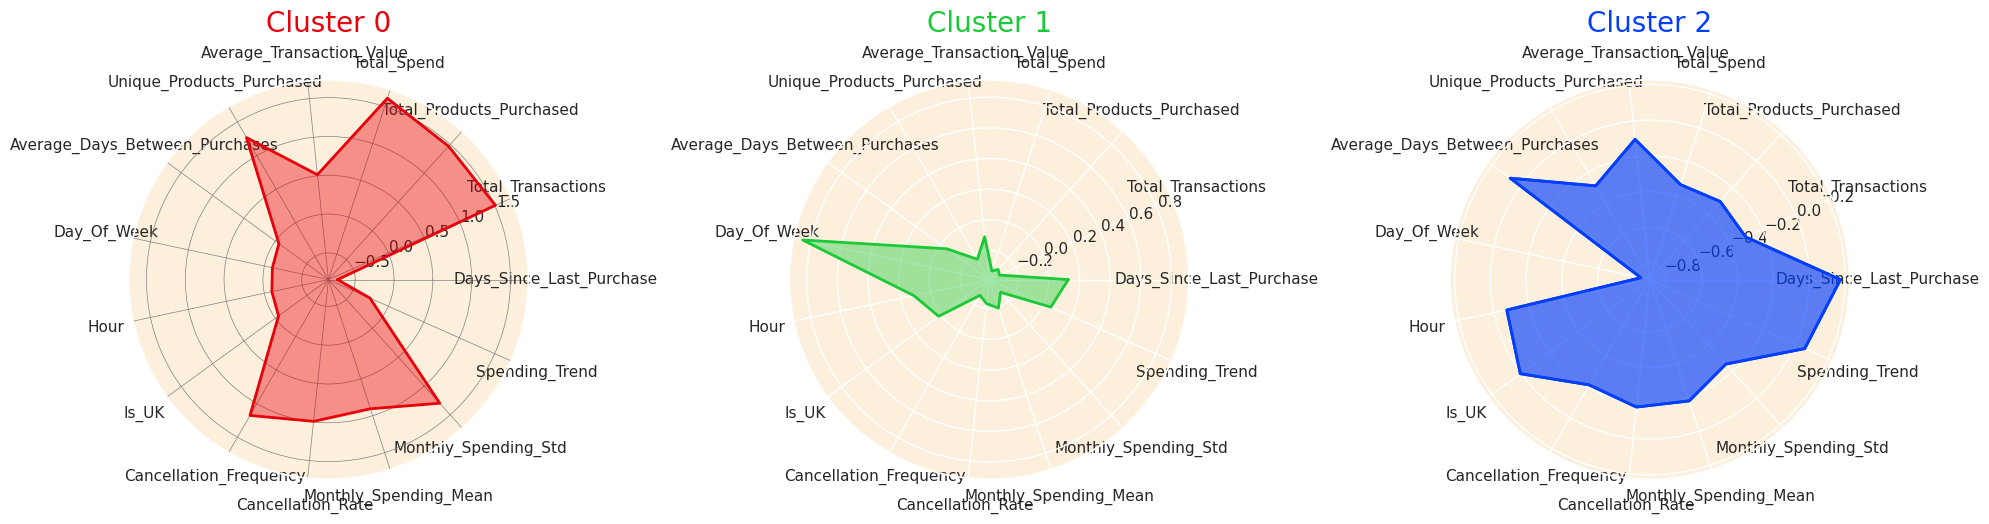

In [ ]:
# Menetapkan kolom 'CustomerID' sebagai indeks dan menetapkannya ke kerangka data baru
df_customer = customer_data_cleaned.set_index('CustomerID')

# Standarisasi data (tidak termasuk kolom cluster)
scaler = StandardScaler()
df_customer_standardized = scaler.fit_transform(df_customer.drop(columns=['cluster'], axis=1))

# Membuat kerangka data baru dengan nilai standar dan tambahkan kembali kolom cluster
df_customer_standardized = pd.DataFrame(df_customer_standardized, columns=df_customer.columns[:-1], index=df_customer.index)
df_customer_standardized['cluster'] = df_customer['cluster']

# Hitunglah titik pusat setiap klaster
cluster_centroids = df_customer_standardized.groupby('cluster').mean()

# Fungsi untuk membuat grafik radar
def create_radar_chart(ax, angles, data, color, cluster):
    # Plot the data and fill the area
    ax.fill(angles, data, color=color, alpha=0.4)
    ax.plot(angles, data, color=color, linewidth=2, linestyle='solid')

    # Tambahkan judul
    ax.set_title(f'Cluster {cluster}', size=20, color=color, y=1.1)

# Tetapkan data
labels=np.array(cluster_centroids.columns)
num_vars = len(labels)

# Hitung sudut setiap sumbu
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Plotnya melingkar, jadi kita perlu "menyelesaikan putaran" dan menambahkan awal ke akhir
labels = np.concatenate((labels, [labels[0]]))
angles += angles[:1]

# Inisialisasi gambar tersebut
fig, ax = plt.subplots(figsize=(20, 10), subplot_kw=dict(polar=True), nrows=1, ncols=3)

# Buat bagan radar untuk setiap klaster
for i, color in enumerate(colors):
    data = cluster_centroids.loc[i].tolist()
    data += data[:1]

    # Gambar radar chart per cluster
    create_radar_chart(ax[i], angles, data, color, i)

# Selesaikan putarannya
create_radar_chart(ax[i], angles, data, color, i)

# Tambahkan data masukan
ax[0].set_xticks(angles[:-1])
ax[0].set_xticklabels(labels[:-1])

ax[1].set_xticks(angles[:-1])
ax[1].set_xticklabels(labels[:-1])

ax[2].set_xticks(angles[:-1])
ax[2].set_xticklabels(labels[:-1])

# Menambahkan kisi
ax[0].grid(color='grey', linewidth=0.5)

# Menampilkan plotnya
plt.tight_layout()
plt.show()

Step 11.2 Histogram Chart Approach

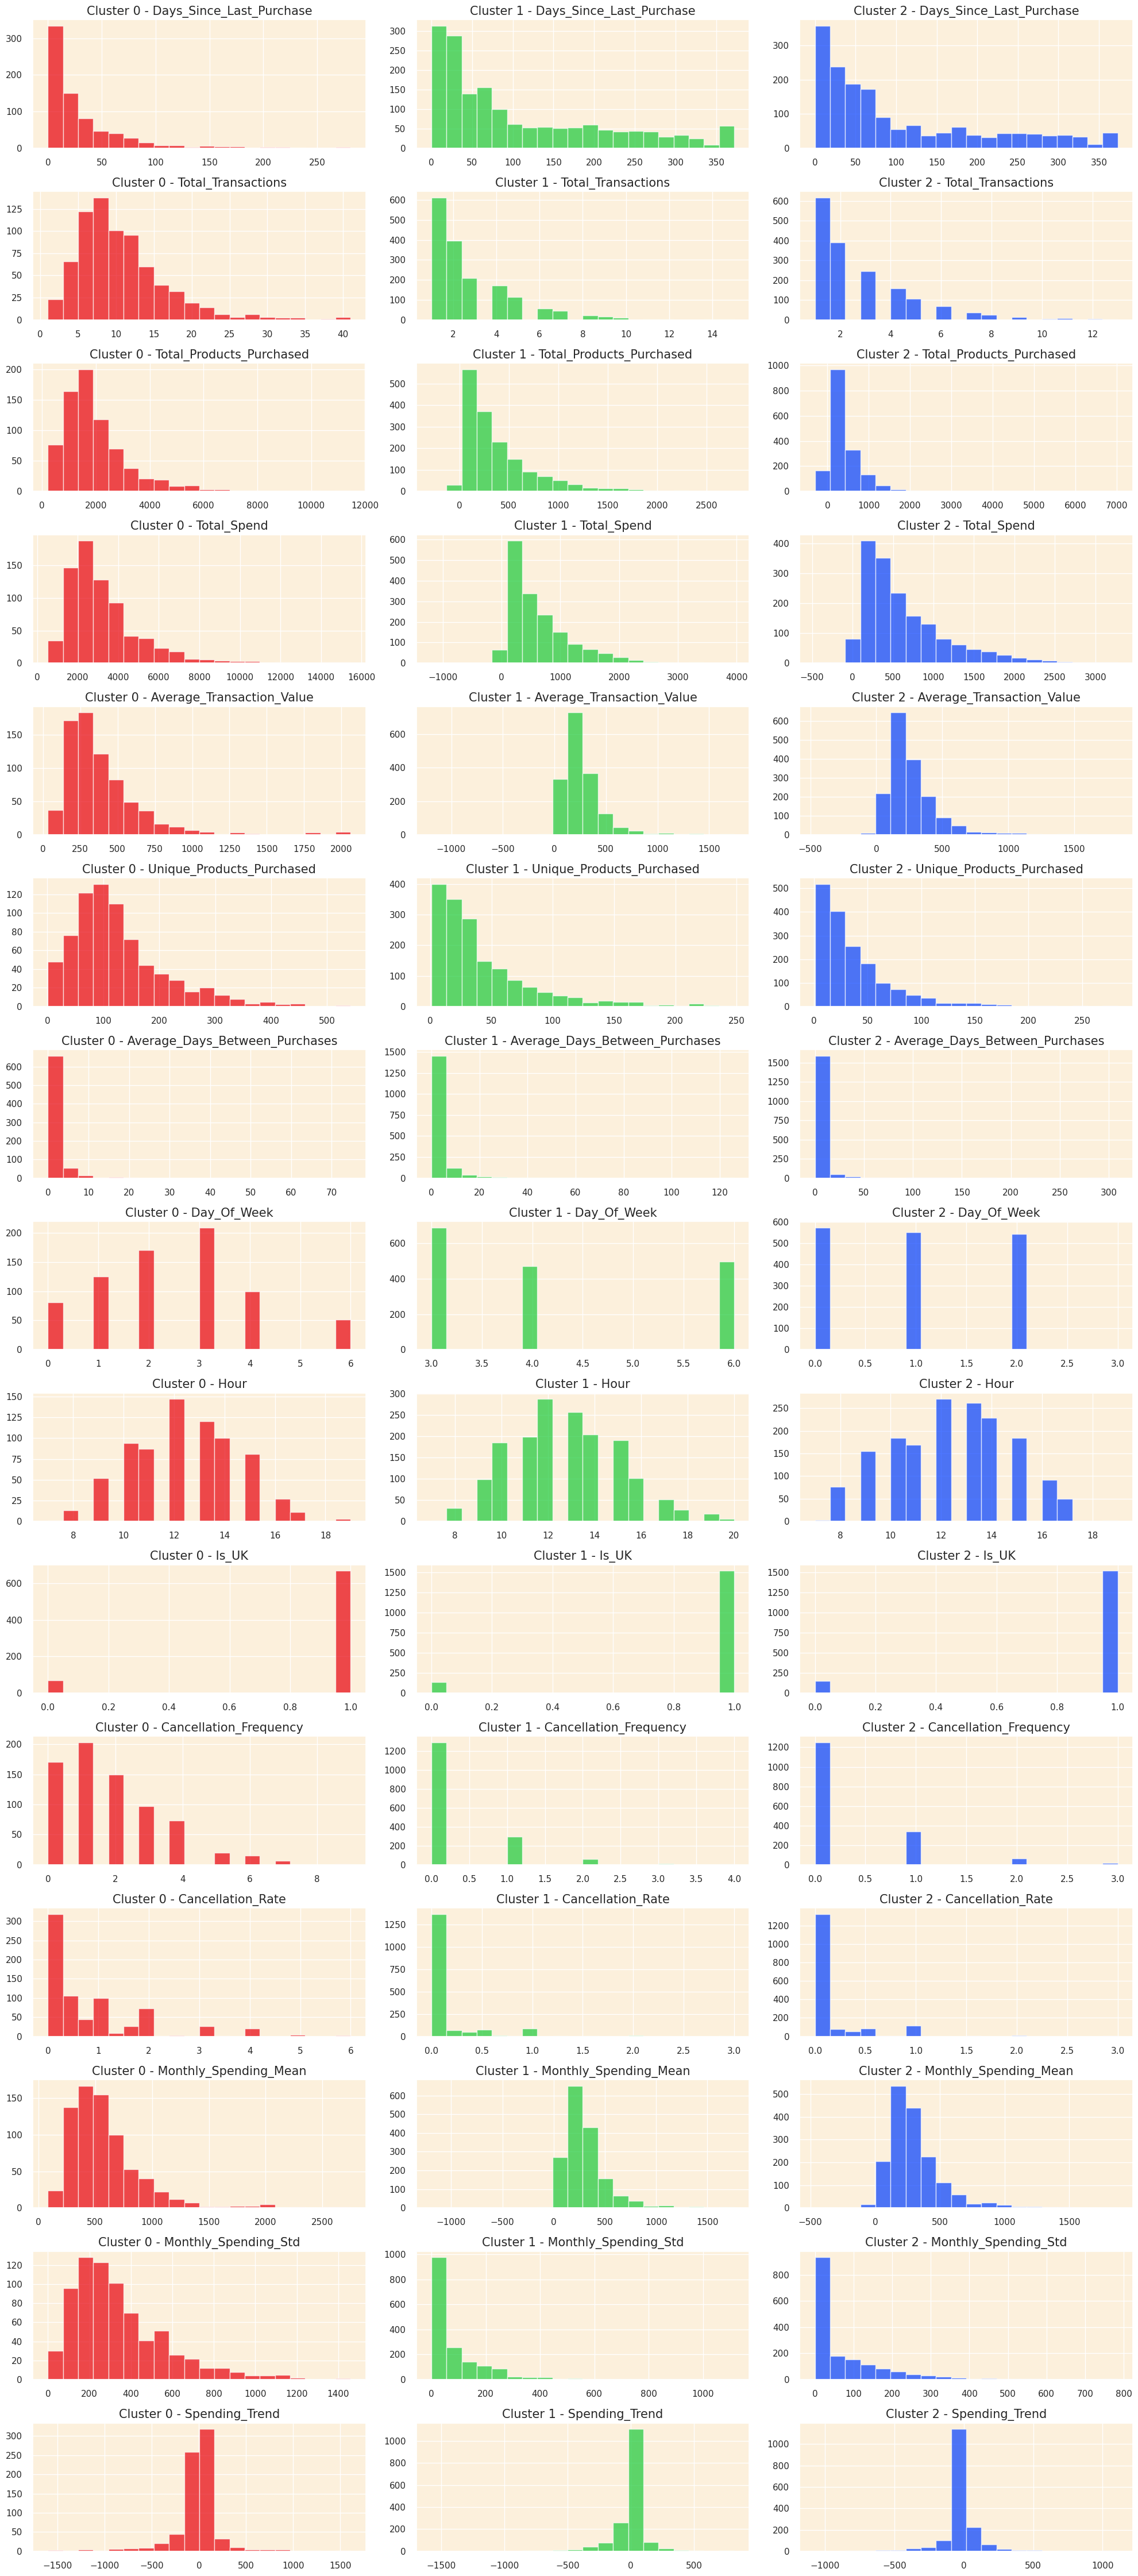

In [ ]:
# Plot histogram untuk setiap fitur yang disegmentasi oleh cluster
features = customer_data_cleaned.columns[1:-1]
clusters = customer_data_cleaned['cluster'].unique()
clusters.sort()

# Menyiapkan subplot
n_rows = len(features)
n_cols = len(clusters)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3*n_rows))

# Memplot histogram
for i, feature in enumerate(features):
    for j, cluster in enumerate(clusters):
        data = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster][feature]
        axes[i, j].hist(data, bins=20, color=colors[j], edgecolor='w', alpha=0.7)
        axes[i, j].set_title(f'Cluster {cluster} - {feature}', fontsize=15)
        axes[i, j].set_xlabel('')
        axes[i, j].set_ylabel('')

# Menyesuaikan tata letak untuk mencegah tumpang tindih
plt.tight_layout()
plt.show()

**Step 12 Recommendation System**

In [ ]:
# Langkah 1: Ekstrak CustomerID dari outlier dan hapus transaksinya dari kerangka data utama
outlier_customer_ids = outliers_data['CustomerID'].astype('float').unique()
df_filtered = df[~df['CustomerID'].isin(outlier_customer_ids)]

# Langkah 2: Pastikan tipe data yang konsisten untuk CustomerID di kedua kerangka data sebelum menggabungkan
customer_data_cleaned['CustomerID'] = customer_data_cleaned['CustomerID'].astype('float')

# Langkah 3: Gabungkan data transaksi dengan data pelanggan untuk mendapatkan informasi cluster untuk setiap transaksi
merged_data = df_filtered.merge(customer_data_cleaned[['CustomerID', 'cluster']], on='CustomerID', how='inner')

# Langkah 4: Identifikasi 10 produk terlaris di setiap klaster berdasarkan jumlah total yang terjual
best_selling_products = merged_data.groupby(['cluster', 'StockCode', 'Description'])['Quantity'].sum().reset_index()
best_selling_products = best_selling_products.sort_values(by=['cluster', 'Quantity'], ascending=[True, False])
top_products_per_cluster = best_selling_products.groupby('cluster').head(10)

# Langkah 5: Buat catatan produk yang dibeli oleh setiap pelanggan di setiap cluster
customer_purchases = merged_data.groupby(['CustomerID', 'cluster', 'StockCode'])['Quantity'].sum().reset_index()

# Langkah 6: Hasilkan rekomendasi untuk setiap pelanggan di setiap klaster
recommendations = []
for cluster in top_products_per_cluster['cluster'].unique():
    top_products = top_products_per_cluster[top_products_per_cluster['cluster'] == cluster]
    customers_in_cluster = customer_data_cleaned[customer_data_cleaned['cluster'] == cluster]['CustomerID']

    for customer in customers_in_cluster:
        # Identifikasi produk yang sudah dibeli oleh pelanggan
        customer_purchased_products = customer_purchases[(customer_purchases['CustomerID'] == customer) &
                                                         (customer_purchases['cluster'] == cluster)]['StockCode'].tolist()

        # Menemukan 3 produk teratas dalam daftar terlaris yang belum dibeli pelanggan
        top_products_not_purchased = top_products[~top_products['StockCode'].isin(customer_purchased_products)]
        top_3_products_not_purchased = top_products_not_purchased.head(3)

        # Menambahkan rekomendasi ke dalam daftar
        recommendations.append([customer, cluster] + top_3_products_not_purchased[['StockCode', 'Description']].values.flatten().tolist())

# Langkah 7: Buat kerangka data dari daftar rekomendasi dan gabungkan dengan data pelanggan asli
recommendations_df = pd.DataFrame(recommendations, columns=['CustomerID', 'cluster', 'Rec1_StockCode', 'Rec1_Description', \
                                                 'Rec2_StockCode', 'Rec2_Description', 'Rec3_StockCode', 'Rec3_Description'])
customer_data_with_recommendations = customer_data_cleaned.merge(recommendations_df, on=['CustomerID', 'cluster'], how='right')

In [ ]:
# Menampilkan 10 baris acak dari kerangka data customer_data_with_recommendations
customer_data_with_recommendations.set_index('CustomerID').iloc[:, -6:].sample(10, random_state=0)

,Rec1_StockCode,Rec1_Description,Rec2_StockCode,Rec2_Description,Rec3_StockCode,Rec3_Description
CustomerID,,,,,,
13243.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
13232.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
14997.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
14948.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
12596.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
16686.0,22616,PACK OF 12 LONDON TISSUES,85099B,JUMBO BAG RED RETROSPOT,84879,ASSORTED COLOUR BIRD ORNAMENT
17101.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
14954.0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,84879,ASSORTED COLOUR BIRD ORNAMENT,15036,ASSORTED COLOURS SILK FAN
18123.0,18007,ESSENTIAL BALM 3.5G TIN IN ENVELOPE,84879,ASSORTED COLOUR BIRD ORNAMENT,17003,BROCADE RING PURSE
